In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

# Functions

In [2]:
def expand_c(c, nn=1):
    """
    input: c -- 2D numpy array
           nn -- number of ghost layers per side per dimension
    """
    NX,NY = np.shape(c)
    
    ## Add periodic boundary condition by expanding c
    
    c_expand = np.zeros((nn+NX+nn,nn+NY+nn))
    
    c_expand[1:-1,1:-1] = c[:,:]
    
    c_expand[0,1:-1] = c[-1,:] 
    c_expand[-1,1:-1] = c[0,:] 
    c_expand[1:-1,0] = c[:,-1] 
    c_expand[1:-1,-1] = c[:,0] 
    
    return c_expand


In [3]:
def laplacian(c):
    """
    input: c - 2D array, with shape NX,NY
    
    output: laplacian of X, using periodic boundary
    """
    NX,NY = np.shape(c)
    c_expand = expand_c(c)
    claplace = np.zeros((NX,NY))

    for i in range(NX):
        for j in range(NY):

            cxx = (c_expand[i+1, j+2] + c_expand[i+1, j] -2*c_expand[i+1,j+1])/DX**2 # all indices add one to translate c to c_expand 
            cyy = (c_expand[i+2, j+1] + c_expand[i, j+1] -2*c_expand[i+1,j+1])/DY**2
            claplace[i,j] = cxx + cyy
    
    return claplace
        

In [4]:
def mu_of_c(c, cm=0, cp=1, a_squared=1): 
    """
    Chemical potential as a function of concentration
    input: c -- float or nd numpy array, concentration
           cm -- concentration corresponding to the left well
           cp -- concentration corresponding to the right well
           a_squared -- energy scale 
    """
    mu = 1/2*a_squared*(c - cm)**2*(c - cp)**2
    
    return mu
    
def derivative_mu(c, cm=0, cp=1, a_squared=1): 
    """
    The derivative of chemical potential with respect to concentration
    input: c -- float or nd numpy array, concentration
           cm -- concentration corresponding to the left well
           cp -- concentration corresponding to the right well
           a_squared -- energy scale 
    """
    
    partial_mu = a_squared * (c - cm) * (c - cp) * (2*c - cm - cp)
    
    return partial_mu



In [5]:
## Computing kernal
def ch_kernal(c, dt=1e-2, D=1, a_squared=1, cm=0, cp=1, epsilon_squared=1):
    """
    inputs: 
    c -- 2d numpy array, initial concentration field
    dt: time difference
    cm -- concentration corresponding to the left well
    cp -- concentration corresponding to the right well
    a_squared -- energy scale 
    
    output:
    c field after one iteration
    """
    
    der_mu = derivative_mu(c, cm=0, cp=1, a_squared=1)
    
    c += D * dt * laplacian(der_mu  - epsilon_squared * laplacian(c))
    
    #return c
 

# Run model

In [24]:
#Input metadata and initial condition

# Physical parameters
DIFFUSION_COEFFICIENT = 1
MU_SCALE = 1
C_MINUS = 0
C_PLUS = 1
PENALTY_SCALE = 0.3

#Grids
NX = 50
NY = 50
DX = 1
DY = 1

# Initial conditions
INITIAL_MEAN = 0.5
INITIAL_VARIANCE = 0.01
Initial_Conditions = np.random.normal(loc=INITIAL_MEAN, scale=np.sqrt(INITIAL_VARIANCE), size=(NX,NY))

np.shape(Initial_Conditions)

(50, 50)

In [25]:
c = Initial_Conditions

dexp = -5
elapsed = 0.

duration = 20

it_num = 0

with tqdm(total=duration) as pbar:
    
    while elapsed < duration:
        
        if it_num % 100 == 0:
            np.savetxt(f'test_data/timepoint {elapsed:.2f}.csv', c, delimiter=',')
        
        dt = min(100, np.exp(dexp))
        elapsed += dt
        dexp += 0.01
        it_num+=1
        pbar.update(dt)
        
        ch_kernal(c, 
                  dt=dt, 
                  D=DIFFUSION_COEFFICIENT, 
                  a_squared=MU_SCALE, 
                  cm=C_MINUS, 
                  cp=C_PLUS, 
                  epsilon_squared=PENALTY_SCALE)
                  
print(f'{it_num} of iterations were computed')

100%|███████████████████████████| 20.030237673863343/20 [00:03<00:00,  5.37it/s]

343 of iterations were computed


# Read data and plot

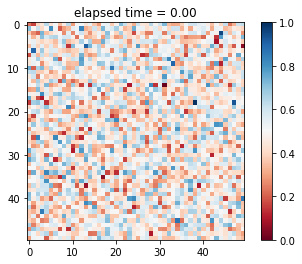

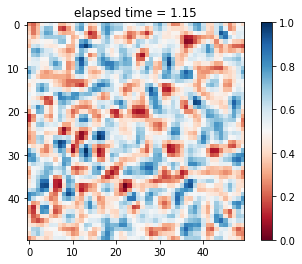

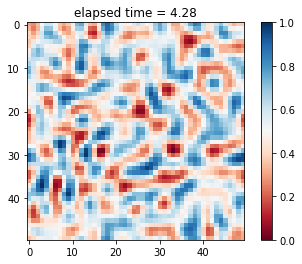

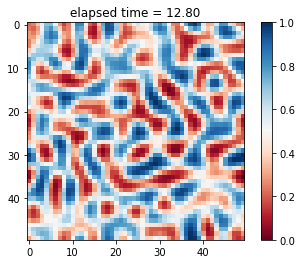

In [38]:
timepoints = ['0.00','1.15','4.28','12.80']

for timepoint in timepoints:
    
    snap = np.loadtxt(f'test_data/timepoint {timepoint}.csv', delimiter = ',')

    fig, ax = plt.subplots()
    pcm = ax.imshow(snap , cmap='RdBu' ,vmin=0, vmax=1)
    fig.colorbar(pcm, ax=ax)
    ax.set_title(f'elapsed time = {timepoint}')
    plt.imshow(snap,cmap='RdBu')
    plt.savefig(f'test_data/timepoint {timepoint}.png')


# Appendix tests

In [ ]:
# test laplacian 
a = np.hstack([np.arange(10)**3,np.arange(10,0,-1)**3])
b = np.hstack([np.arange(0,100,10)**2,np.arange(100,0,-10)**2]).reshape(-1,1)
test = a+b
fig, axes = plt.subplots(1,2, figsize = (10,4))
axes = axes.ravel()
pcm = axes[0].imshow(test)
plt.colorbar(pcm, ax = axes[0])
pcm = axes[1].imshow(laplacian(test))
plt.colorbar(pcm, ax = axes[1])